# Εισαγωγή

Εισαγωγή βιβλιοθηκών

In [ ]:
import os
import numpy as np
import imageio
import cv2
import PIL
import matplotlib.pyplot as plt
from scipy import ndimage
from osgeo import gdal, gdal_array, gdalconst

Ορισμός συναρτήσεων

In [ ]:
def geoimread(filename):
    # Usage:
    # (imdata, geoTransform, proj, drv_name) = geoimread('example.tif')
    
    # Open file
    dataset = gdal.Open(filename, gdalconst.GA_ReadOnly)

    # Read image
    imdata = gdal_array.DatasetReadAsArray(dataset)
    
    # If there are multiple bands in the dataset
    # (meaning: if there is a third dimension on imdata)
    if len(imdata.shape) == 3:
        imdata = np.swapaxes(imdata, 0, 1 )
        imdata = np.swapaxes(imdata, 1, 2 )
    
    # Get the Driver name (filetype)
    drv_name = dataset.GetDriver().ShortName
       
    # Get Georeference info
    geoTransform = dataset.GetGeoTransform()
    proj = dataset.GetProjection()
    
    # Clear variable
    dataset = None

    return(imdata, geoTransform, proj, drv_name)

def geoimwrite(filename, imdata, geoTransform, proj, drv_name):    
    # Usage:
    # geoimwrite('example.tif', image_array, geoTransform, proj, drv_name)
    
    # Get the image Driver by its short name
    driver = gdal.GetDriverByName(drv_name)

    # Get image dimensions from array
    image_shape = np.shape(imdata)
    if len(image_shape) == 3: # multiband
        [bands, rows, cols] = image_shape
    elif len(image_shape) == 2: #singleband
        [rows, cols] = image_shape
        bands = 1
    
    # Image datatype
    dt = imdata.dtype
    datatype = gdal.GetDataTypeByName( dt.name )
	
    # Prepare the output dataset
    if datatype == 0:
        # Unknown datatype, try to use uint8 code
        datatype = 1

    # Create Output file
    outDataset = driver.Create(filename, cols, rows, bands, datatype)

    # Set the Georeference first
    outDataset.SetGeoTransform(geoTransform)
    outDataset.SetProjection(proj)
    
    # Write image data
    if bands == 1:
        outBand = outDataset.GetRasterBand(1)
        outBand.WriteArray(imdata)
    else:
        for band_index in range(0,bands):
            band_number = band_index + 1
            outBand = outDataset.GetRasterBand(band_number)
            outBand.WriteArray(imdata[band_index,:,:])
    
    # Clear variables and close the file
    outBand = None
    outDataset = None

# Ερώτημα 1

Να εισάγετε και να απεικονίσετε τις τηλεπισκοπικές εικόνες με διάφορα έγχρωμα σύνθετα. Να περιγράψετε
χαρακτηριστικά στοιχεία και βασικές διαφορές που παρατηρείτε (πχ. δόμηση, εποχή λήψης, κοκ.) μεταξύ τους.

Φάκελος εργασίας

In [ ]:
# Change current working directory
path = '/content/drive/MyDrive/Data/'
os.chdir(path)

Ονόματα εικόνων

In [ ]:
# Set filenames
filename1 = '2006_QuickBird_grid10.tif'
filename2 = '2011_WorldView2_grid10.tif'

Εισαγωγή εικόνων

In [ ]:
# Read data
(im06, geoTransform, proj, drv_name) = geoimread(filename1)
(im11, geoTransform, proj, drv_name) = geoimread(filename2)

Μετατροπή τιμών από uint16 (0-65535) σε uint8 (0-255)

Εύρεση μέγιστης τιμής όλων των καναλιών κάθε εικόνας

In [ ]:
# Find maximum of both images
max06 = np.amax(im06)
max11 = np.amax(im11)

Μετατροπή τύπου μεταβλητής σε δεκαδικό αριθμό (προετοιμασία για την πραγματοποίηση διαίρεσης)

In [ ]:
# Convert image type to float
im06 = im06.astype(np.float32)
im11 = im11.astype(np.float32)

Εύρεση μεγαλύτερης από τις δύο μέγιστες τιμές, διαίρεση όλων των εικόνων με αυτή, 
για τη μετατροπη των τιμών από το διάστημα (0, μέγιστο) στο διάστημα (0-1)

In [ ]:
# Convert to 0-1 by dividing by largest mx
if mx06 > mx11: # if im06 has a larger max value
    im06 = im06 / max06
    im11 = im11 / max06
else: # if im11 has a larger max value
    im06 = im06 / max11
    im11 = im11 / max11

Μετατροπή τιμών από δεκαδικούς αριθμούς στο διάστημα (0-1) σε ακέραιους αριθμούς στο διάστημα (0-255)

In [ ]:
# Multiplication by 255
im06 = im06*255
im11 = im11*255

Μετατροπή τύπου μεταβλητής σε uint8

In [ ]:
# Convert data to uint8 to be able to run PIL and cv2 functions
im06 = im06.astype(np.uint8)
im11 = im11.astype(np.uint8)

Έγχρωμο σύνθετο RGB: 432 (QuickBird) 753 (WorldView-2)

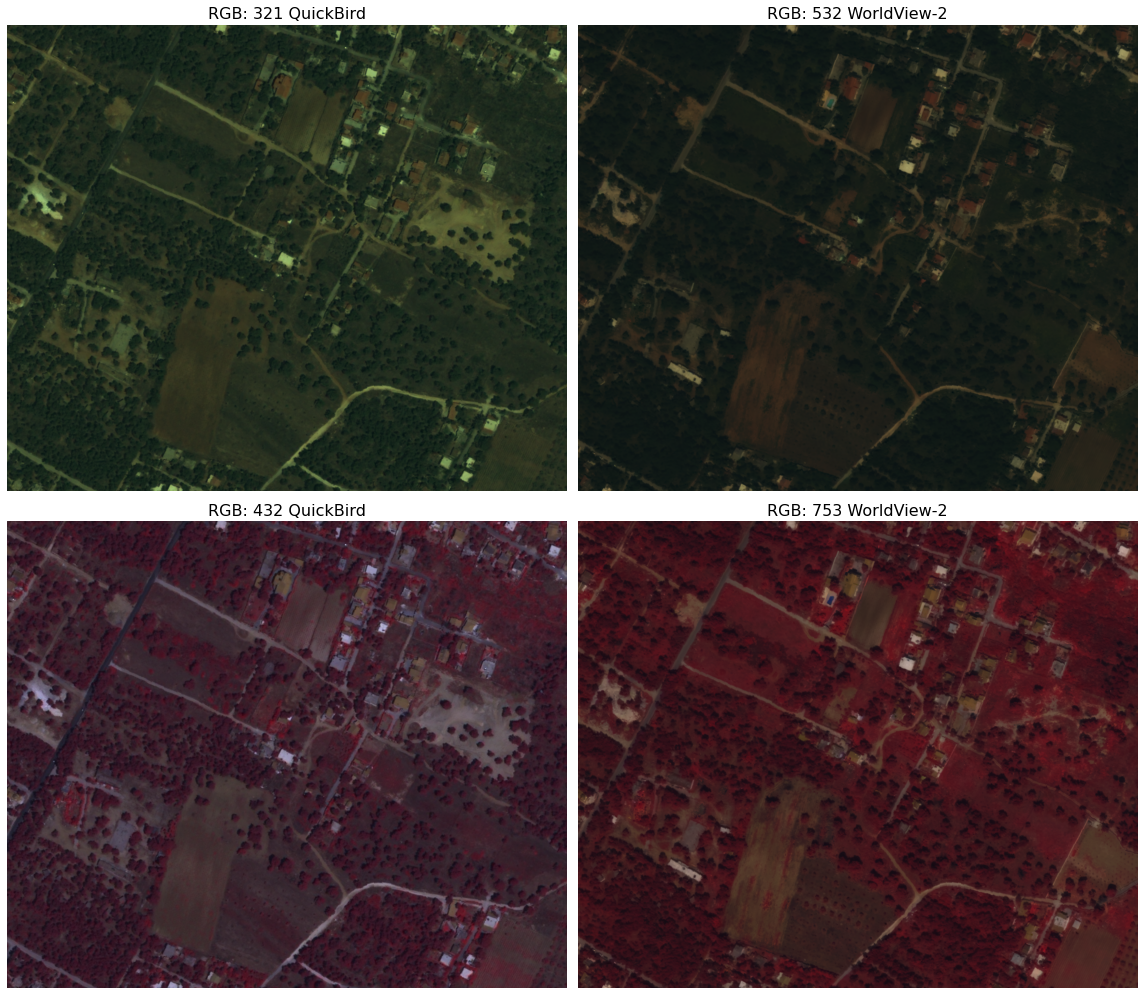

In [ ]:
# Natural Color Composite
qb_cc = np.array([3,2,1])-1 #  indices Quickbird
qb_321 = im06[:,:,qb_cc] # image Quickbird

wv2_cc = np.array([5,3,2])-1 # indices WorldView-2
wv2_532 = im11[:,:,wv2_cc] # image WorldView-2

# Infrared Color Composite
qb_cc = np.array([4,3,2])-1 # indices Quickbird
qb_432 = im06[:,:,qb_cc] # image Quickbird

wv2_cc = np.array([7,5,3])-1 # indices WorldView-2
wv2_753 = im11[:,:,wv2_cc] # image WorldView-2


f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 14)) # Create Figure with subplots

ax[0,0].imshow(qb_321) # Show image in specific subplot axis
ax[0,0].set_title("RGB: 321 QuickBird", fontsize=16) # Set subplot axis title
ax[0,0].axis('off') # Hide subplot axis ticks

ax[0,1].imshow(wv2_532) # Show image in specific subplot axis
ax[0,1].set_title("RGB: 532 WorldView-2", fontsize=16) # Set subplot axis title
ax[0,1].axis('off') # Hide subplot axis ticks

ax[1,0].imshow(qb_432) # Show image in specific subplot axis
ax[1,0].set_title("RGB: 432 QuickBird", fontsize=16) # Set subplot axis title
ax[1,0].axis('off') # Hide subplot axis ticks

ax[1,1].imshow(wv2_753) # Show image in specific subplot axis
ax[1,1].set_title("RGB: 753 WorldView-2", fontsize=16) # Set subplot axis title
ax[1,1].axis('off') # Hide subplot axis ticks

plt.tight_layout() # Reduce empty space between subplots
plt.show() # Display images

# Ερώτημα 2

Να εμφανίσετε τα ιστογράμματα τους (για κάθε κανάλι ξεχωριστά) και να εντοπίσετε τις ακραίες και τις χαρακτηριστικές
τιμές τους (μέση τιμή, τυπική απόκλιση). Να πραγματοποιήσετε και να αξιολογήσετε τεχνικές ενίσχυσης ιστογράμματος
τόσο για την βελτίωση της απεικόνισης όσο και για την ανάδειξη συγκεκριμένων φασματικών χαρακτηριστικών (πχ.
θάλασσα, αστικό, καλλιέργειες κλπ). Να εκτελέσετε και στη συνέχεια να σχολιάσετε την ισοδυναμοποίηση
ιστογράμματος.



Εμφάνιση Ιστογράμματος

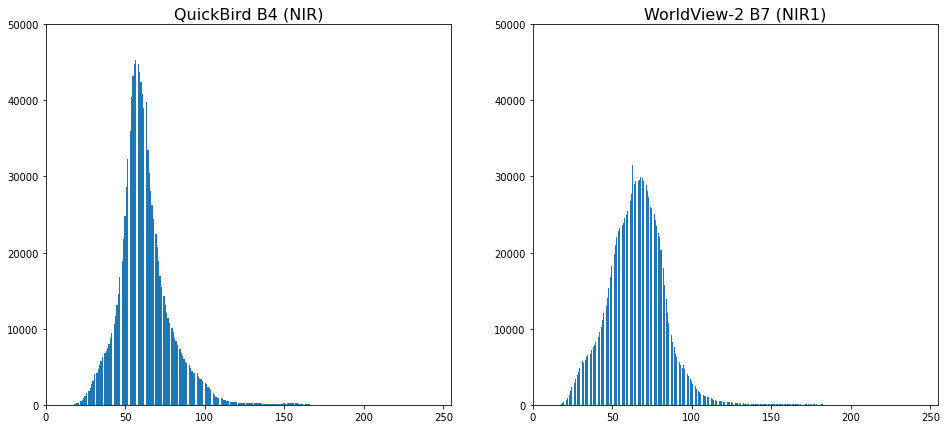

In [ ]:
# Calculate and display image histogram of the infrared band
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7)) # Create Figure with subplots

band_data = im06[:,:,3].flatten() # Reduce dimensions to a 1d array
(hist,bins,patches) = ax[0].hist(band_data,255) # Calculate and show histogram
ax[0].set_title("QuickBird B4 (NIR)", fontsize=16) # Set title
ax[0].set_xlim((0,255)) # Set axis limits
ax[0].set_ylim((0,50000))

band_data = im11[:,:,6].flatten() # Reduce dimensions to a 1d array
(hist,bins,patches) = ax[1].hist(band_data,255) # Calculate and show histogram
ax[1].set_title("WorldView-2 B7 (NIR1)", fontsize=16) # Set title
ax[1].set_xlim((0,255)) # Set axis limits
ax[1].set_ylim((0,50000))

plt.show() # Show output

Υπολογισμός μέσης τιμής και τυπικής απόκλισης ανά κανάλι

In [ ]:
band_names = ['Blue','Green','Red','NIR'] # QuickBird band names 
print('Quickbird')
for band_index, band_name in enumerate(band_names): # for each Quickbird band name
  m0 = im06[:,:,band_index].mean() # calculate mean
  s0 = im06[:,:,band_index].std() # calculate standard deviation
  # Print them
  print(' ')  # Empty line
  print ('Mean value of', band_name, 'band is:', int(m0))
  print ('Standard deviation of', band_name, 'band is:', int(s0))


Quickbird
 
Mean value of Blue band is: 31
Standard deviation of Blue band is: 8
 
Mean value of Green band is: 48
Standard deviation of Green band is: 17
 
Mean value of Red band is: 37
Standard deviation of Red band is: 18
 
Mean value of NIR band is: 62
Standard deviation of NIR band is: 16


Οπτική Ενίσχυση εικόνων

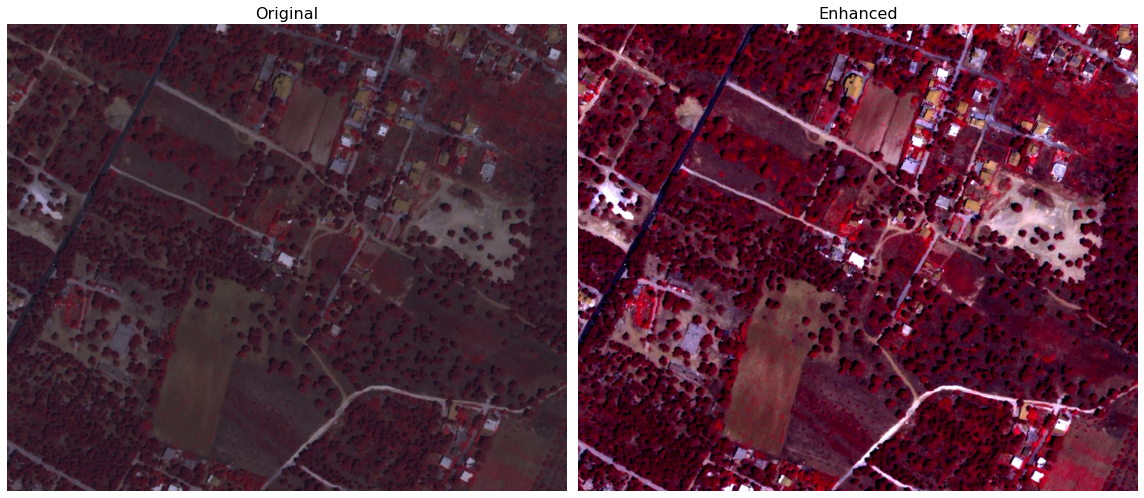

In [ ]:
im = PIL.Image.fromarray(qb_432) # Convert from numpy array to PIL Image
enh = PIL.ImageEnhance.Contrast(im) # Create enhancer object
outimg=enh.enhance(3) # Apply enhancement by a factor of 3

# Show comparison
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7)) # Create Figure with subplots
ax[0].imshow(qb_432) # Show image in specific subplot axis
ax[0].set_title("Original", fontsize=16) # Set subplot axis title
ax[0].axis('off') # Hide subplot axis ticks
ax[1].imshow(outimg) # Show image in specific subplot axis
ax[1].set_title("Enhanced", fontsize=16) # Set subplot axis title
ax[1].axis('off') # Hide subplot axis ticks

plt.tight_layout() # Reduce empty space between subplots
plt.show() # Display images

Ισοδυναμοποίηση ιστογράμματος

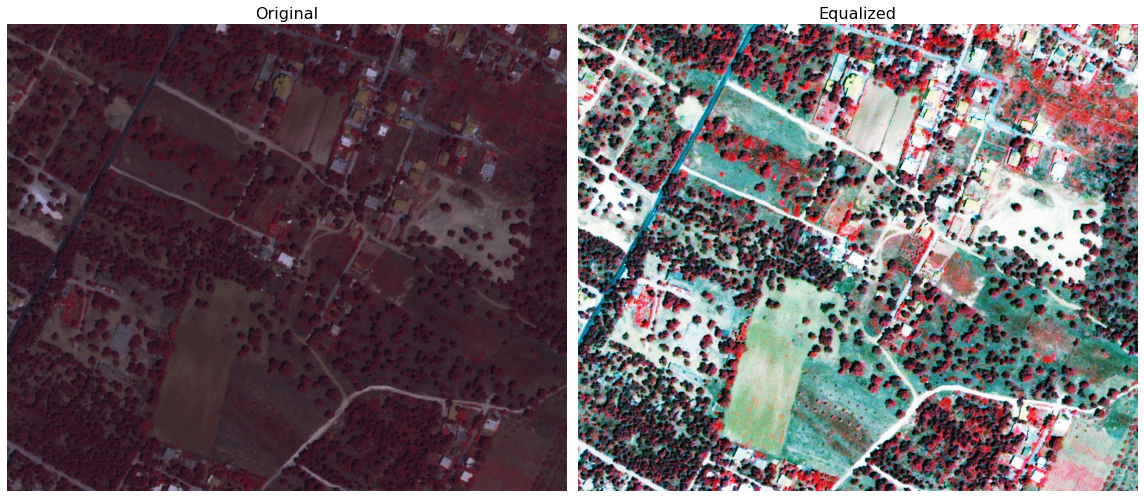

In [ ]:
equ = np.copy(qb_432) # Initialize equalized image
for b in range (0,3): # For each band
    equ[:,:,b] = cv2.equalizeHist(qb_432[:,:,b]) # Perform Histogram Equalization

# Show comparison
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
ax[0].imshow(qb_432) # Show image in specific subplot axis
ax[0].set_title("Original", fontsize=16) # Set subplot axis title
ax[0].axis('off') # Hide subplot axis ticks
ax[1].imshow(equ) # Show image in specific subplot axis
ax[1].set_title("Equalized", fontsize=16) # Set subplot axis title
ax[1].axis('off') # Hide subplot axis ticks

plt.tight_layout() # Reduce empty space between subplots
plt.show() # Display images

# Ερώτημα 3

Επιλέξτε και εφαρμόστε φίλτρα για την αφαίρεση του θορύβου. Σχολιάστε και αξιολογήστε τα αποτελέσματα

In [ ]:
# Ready-to-use filters from SciPy
# Median filtering
med_img = ndimage.filters.median_filter(equ[:,:,0],7)
plt.imshow(med_img,cmap='gray')
plt.imshow(equ[:,:,0],cmap='gray')
imageio.imwrite('IR_06_equ.png',equ[:,:,0])
imageio.imwrite('IR_06_equ_median_7x7.png',med_img)
plt.show()
plt.close()

gauss_img = ndimage.filters.gaussian_filter(equ[:,:,0],5)
plt.imshow(gauss_img,cmap='gray')
plt.imshow(equ[:,:,0],cmap='gray')

imageio.imwrite('IR_06_equ_gaussian_5x5.png',gauss_img)
plt.show()
plt.close()

# Ερώτημα 4

Εφαρμόστε φίλτρα ανίχνευσης ακμών. Σχολιάστε και αξιολογήστε το αποτέλεσμα.

In [ ]:
########## EROTIMA 4 ##########

# Sobel (edge finding operator)
# Horizontal sobel gradient
gx = ndimage.filters.sobel(np.single(med_img),0)
# Vertical sobel gradient
gy = ndimage.filters.sobel(np.single(med_img),1)
# Sobel image = Total gradient magnitude
sobel_img = np.sqrt(gx**2 + gy**2)
imageio.imwrite('IR_06_equ_median_3x3_sobelx.png',np.sqrt(gx**2))
imageio.imwrite('IR_06_equ_median_3x3_sobely.png',np.sqrt(gy**2))
imageio.imwrite('IR_06_equ_median_3x3_sobel.png',sobel_img)
plt.imshow(sobel_img, cmap='gray')
sobel_thresh = sobel_img>200
plt.imshow(sobel_thresh, cmap='gray')
plt.show()

pre = ndimage.filters.prewitt(np.single(med_img))
plt.imshow(pre, cmap='gray')
pre_thresh = pre>100
plt.imshow(pre_thresh, cmap='gray')
plt.show()

# Ερώτημα 5

Με βάση τη βιβλιογραφία και τους πειραματισμούς σας στα παραπάνω βήματα, επιλέξτε κάποιο συνδυασμό
επεξεργασιών (πχ: -δείκτη βλάστησης, δείκτη ανθρωπογενών κατασκευών, κατωφλίωση, κοκ, -φίλτρο ομαλοποίησης,
ανίχνευση ακμών, κατωφλίωση, κοκ) για να ανιχνεύσετε κάποιο χαρακτηριστικό και στις δυο εικόνες και τις πιθανές
διαχρονικές μεταβολές. Σχολιάστε και αξιολογήστε τα αποτελέσματα.

In [ ]:
equ11 = imageio.imread('IRRG_11_equ.png')
equ06 = imageio.imread('IRRG_06_equ.png')

# Convert data to float to be able to compute indices
equ06 = equ06.astype(np.float32)
equ06 = equ06/255
equ11 = equ11.astype(np.float32)
equ11 = equ11/255

NDVI11 = ( equ11[:,:,0] - equ11[:,:,1] ) / ( equ11[:,:,0] + equ11[:,:,1] )
NDVI06 = ( equ06[:,:,0] - equ06[:,:,1] ) / ( equ06[:,:,0] + equ06[:,:,1] )

thresh_NDVI11 = NDVI11 > 0.2
thresh_NDVI11 = (255*thresh_NDVI11).astype(np.uint8)
plt.imshow(thresh_NDVI11, cmap='gray')
plt.show()
imageio.imwrite('NDVI_thresh_11.png',thresh_NDVI11)

thresh_NDVI06 = NDVI06 > 0.5
thresh_NDVI06 = (255*thresh_NDVI06).astype(np.uint8)
plt.imshow(thresh_NDVI06, cmap='gray')
plt.show()
imageio.imwrite('NDVI_thresh_06.png',thresh_NDVI06)
